<a href="https://colab.research.google.com/github/DeaconKaiJ/AlgCom-Sort/blob/master/Copy_of_Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Identification
### <span style="color:red">USE PYTHON 3.7</span>
Jupyter notebook to document and display outputs for live code.
*Currently using test code from tensorflow's image classification* found:
[here](https://www.tensorflow.org/tutorials/images/classification)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Code written here imports required libraries for function

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

In [3]:
from tensorflow.keras.layers import *

In [ ]:
tf.__version__

'2.4.1'

placeholder

In [4]:
import pathlib
!unzip "/content/drive/MyDrive/dog_data.zip" -d dog_file_images
data_dir = "/content/dog_file_images/train"
data_dir = pathlib.Path(data_dir)
print(data_dir)


Streaming output truncated to the last 5000 lines.
  inflating: dog_file_images/train/keeshond/a45fbf6af618701f6dc93eba5729689a.jpg  
  inflating: dog_file_images/train/keeshond/abb194f697f5e00bc8be1e29c54ec3d7.jpg  
  inflating: dog_file_images/train/keeshond/aef239bc996a3b364aba20025acebc3c.jpg  
  inflating: dog_file_images/train/keeshond/b0ba782b54de66ab1c3a340b5cfd9d9a.jpg  
  inflating: dog_file_images/train/keeshond/b7859bc0940bcff3bcd02155742ec4be.jpg  
  inflating: dog_file_images/train/keeshond/b8e09f10cfea58a7bdd11c9280f0690a.jpg  
  inflating: dog_file_images/train/keeshond/bd64158308bbc5e2584e89f6e2ea2ff4.jpg  
  inflating: dog_file_images/train/keeshond/be1032723cc8abb85c6cf81e129e6161.jpg  
  inflating: dog_file_images/train/keeshond/bedcd4451681407aca58ea40c6ac1af3.jpg  
  inflating: dog_file_images/train/keeshond/c259c58c68675139297a4351963628ca.jpg  
  inflating: dog_file_images/train/keeshond/c680c7aa880ab72ae585f401a223470f.jpg  
  inflating: dog_file_images/train/k

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

10222


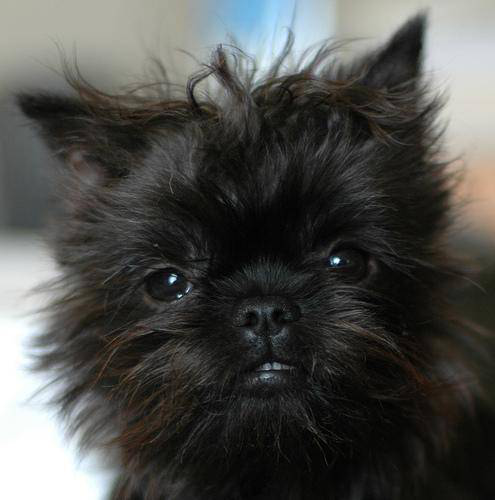

In [6]:
affenpinscher = list(data_dir.glob('affenpinscher/*'))
PIL.Image.open(str(affenpinscher[0]))

In [7]:
batch_size = 32
size = 224
num_classes = 120
epochs = 15
lr = 1e-4

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = "training",
    seed = 123,
    image_size = (size, size),
    batch_size = batch_size)

Found 10222 files belonging to 120 classes.
Using 8178 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (size, size),
  batch_size = batch_size)

Found 10222 files belonging to 120 classes.
Using 2044 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

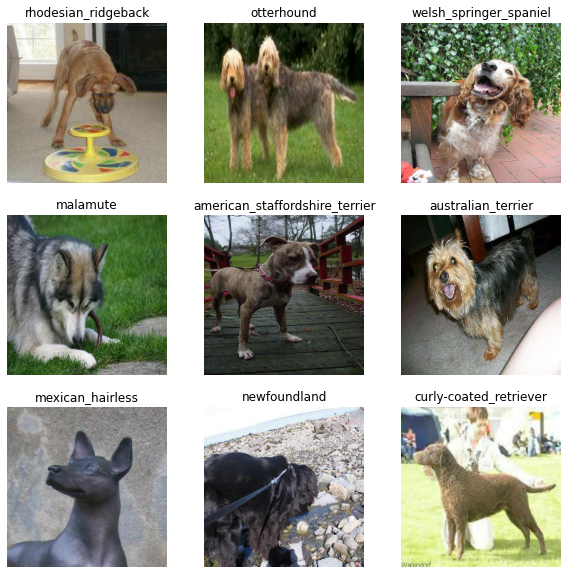

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalisation_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalised_ds = train_ds.map(lambda x, y: (normalisation_layer(x), y))
image_batch, labels_batch = next(iter(normalised_ds))
first_image = image_batch[0]
#Notice the pixels values are now in `[0,1,]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
##I DONT SEE THE NEED FOR THIS AS OUR DATA SET ISNT SMALL??

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(size, 
                                                              size,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

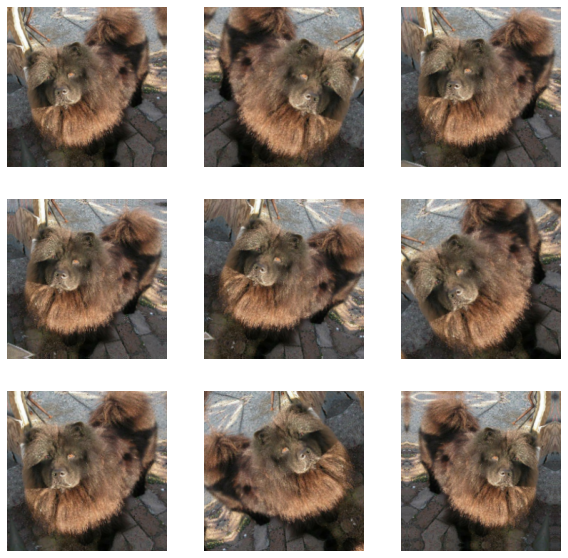

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:

##i DIDNT RUN THIS WHEN I RAN MINE


model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
inputs = Input((size, size, 3))
backbone = ResNet50(input_tensor=inputs, include_top=False, weights="imagenet")
backbone.trainable = True

In [21]:
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, x)

In [22]:
model.compile(optimizer=Adam(lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [19]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
256/256 [==============================] - 131s 364ms/step - loss: 3.7494 - accuracy: 0.1990 - val_loss: 1.7478 - val_accuracy: 0.5122
Epoch 2/15
256/256 [==============================] - 91s 354ms/step - loss: 0.8517 - accuracy: 0.7701 - val_loss: 1.5950 - val_accuracy: 0.5582
Epoch 3/15
256/256 [==============================] - 91s 354ms/step - loss: 0.2565 - accuracy: 0.9375 - val_loss: 1.3656 - val_accuracy: 0.6233
Epoch 4/15
 45/256 [====>.........................] - ETA: 1:09 - loss: 0.0933 - accuracy: 0.9777

KeyboardInterrupt: ignored

**TRAINING RESULTS**

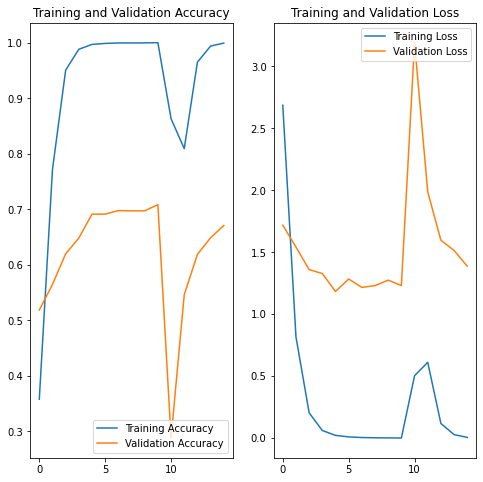

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**PREDICTING DATA**

In [ ]:
test_image = "/content/dog_file_images/test/0077bc3c63486ff09d3774d956af8f76.jpg"

img = keras.preprocessing.image.load_img(
    test_image, target_size=(size, size)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to clumber with a 1.74 percent confidence.
